In [1]:
import tensorflow as tf
from tensorflow import keras
!pip install -U tensorflow-addons
import tensorflow_addons as tfa
!pip install -U efficientnet
import efficientnet.tfkeras as efn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import KFold
import os
import shutil
import random

     |████████████████████████████████| 706kB 4.9MB/s 
     |████████████████████████████████| 51kB 2.9MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [43]:
class CONFIG():
    # dataset_path = "/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset"
    # train_csv_path = "/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset/train.csv"
    # train_folder_path = "/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset/train_images"
    # test_folder_path = "/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset/test_images"
    # submission_path = "/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset/sample_submission.csv"
    # TFRecords_path = "/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset/TFRecords"

    models_path = "/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Models"
    test_folder_path = "/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset/test_images"

    classes = ['complex','frog_eye_leaf_spot','powdery_mildew', 
                'rust','scab','healthy']

    strategy = tf.distribute.get_strategy()
    batch_size = 16
    shuffle_buffer = 2048

    random_seed = 42
    img_size = 512
    folds = 5
    patience_EarlyStopping = 4
    patience_ReduceLR = 2
    reduceLR_factor = 0.1
    min_lr = 1e-8

    epochs = 150
    verbose = 1

In [13]:
def serialize_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [CONFIG.img_size, CONFIG.img_size])
    image = tf.cast(image, tf.uint8)
        
    return tf.image.encode_jpeg(image).numpy()


def serialize_test_sample(image, image_name):
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
        'image_name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_name]))}
    sample = tf.train.Example(features=tf.train.Features(feature=feature))
    return sample.SerializeToString()


def serialize_test():
    samples = []
    
    for image_name in os.listdir(CONFIG.test_folder_path):
        path = os.path.join(CONFIG.test_folder_path, image_name)
        image = serialize_image(path)
        serialized_sample = serialize_test_sample(image, image_name.encode())
        samples.append(serialized_sample)
    
    with tf.io.TFRecordWriter('test.tfrec') as writer:
        [writer.write(x) for x in samples]

serialize_test()

In [31]:
# Dataset Functions

def count_data_items(filenames):
    return np.sum([int(x[:-6].split('-')[-1]) for x in filenames])


feature_map = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string)}


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.reshape(image, [CONFIG.img_size, CONFIG.img_size, 3])
    image = tf.cast(image, tf.float32) / 255.
    return image


def read_tfrecord(example):
    example = tf.io.parse_single_example(example, feature_map)
    image = decode_image(example['image'])
    label = example['image_name']
    return image, label

def augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    image = tf.image.random_hue(image, .1)
    image = tf.image.random_saturation(image, .8, 1.2)
    image = tf.image.random_contrast(image, .8, 1.2)
    image = tf.image.random_brightness(image, .1)

    # rotation -15 to 15 deg counterclockwise
    k_rad = tf.random.uniform([CONFIG.batch_size], minval=-0.2618, maxval=0.2618, dtype=tf.dtypes.float32)
    image = tfa.image.rotate(image, k_rad)

    for _ in range(5):
        image = tfa.image.random_cutout(image, mask_size=50)
    
    image = tf.clip_by_value(image, 0.0, 1.0)
    image = tf.reshape(image, [-1, CONFIG.img_size, CONFIG.img_size, 3])
    return image, label


def get_dataset(filenames, labeled=True, augment=False, repeat=False, shuffle=False, cache=False):
    AUTO = tf.data.experimental.AUTOTUNE
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    if shuffle:
        dataset = dataset.shuffle(CONFIG.shuffle_buffer)
    dataset = dataset.batch(CONFIG.batch_size, drop_remainder=False)
    if augment:
        dataset = dataset.map(augmentation, num_parallel_calls=AUTO)
    if repeat:
        dataset = dataset.repeat()
    if cache:
        dataset = dataset.cache()
    
    dataset = dataset.prefetch(AUTO)
    return dataset


# filenames = tf.io.gfile.glob(os.path.join(CONFIG.TFRecords_path, 'fold_0/*.tfrec'))[:1]


# dataset = get_dataset(filenames, augment=False)

# plt.figure(figsize=[15, 15])
# for i, sample in enumerate(dataset.unbatch().take(5).as_numpy_iterator()):
#     plt.subplot(1, 5, i + 1)
#     plt.imshow(sample[0])
#     plt.title(sample[1])
#     plt.axis('off')
# plt.show()

# def get_model():
#     model = tf.keras.models.Sequential(name='EfficientNetB4-noisy-student')
    
#     model.add(efn.EfficientNetB4(
#         include_top=False,
#         input_shape=(CONFIG.img_size, CONFIG.img_size, 3),
#         weights='noisy-student',
#         pooling='avg'))
    
#     model.add(tf.keras.layers.Dense(len(CONFIG.classes), 
#         kernel_initializer=tf.keras.initializers.RandomUniform(),
#         bias_initializer=tf.keras.initializers.Zeros(), name='dense_top'))
#     model.add(tf.keras.layers.Activation('sigmoid', dtype='float32'))
    
#     return model

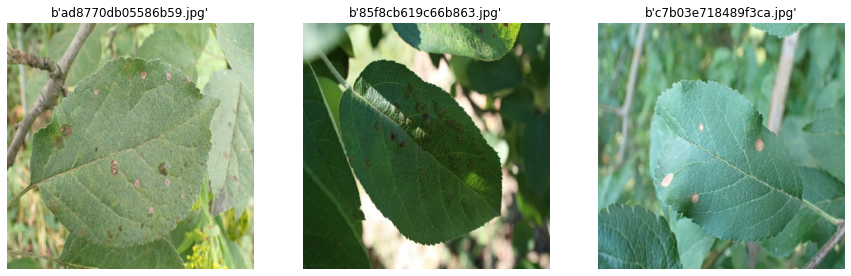

In [36]:
dataset = get_dataset(f"test.tfrec")

plt.figure(figsize=[15, 15])
for i, sample in enumerate(dataset.unbatch().take(3).as_numpy_iterator()):
    plt.subplot(1, 3, i + 1)
    plt.imshow(sample[0])
    plt.title(sample[1])
    plt.axis('off')
plt.show()

In [57]:
tf.io.gfile.glob(f"{CONFIG.test_folder_path}/*")

['/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset/test_images/ad8770db05586b59.jpg',
 '/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset/test_images/85f8cb619c66b863.jpg',
 '/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset/test_images/c7b03e718489f3ca.jpg']

In [60]:
model_paths = tf.io.gfile.glob(f"{CONFIG.models_path}/EfficientNetB4-noisy-student/m*.h5")

dataset = get_dataset("test.tfrec")

test_len = len(tf.io.gfile.glob(f"{CONFIG.test_folder_path}/*"))
predicts = np.zeros((test_len, len(CONFIG.classes)))
for path in model_paths:

    with CONFIG.strategy.scope():
        model = keras.models.load_model(path)
    
    predicts += model.predict(dataset)
predicts = predicts/len(model_paths)

In [74]:
predicts/len(model_paths)

array([[4.50255799e-01, 7.14025867e-01, 2.41080743e-04, 1.37787461e-03,
        7.42792761e-01, 1.01682134e-05],
       [3.22030121e-01, 6.39655398e-03, 3.50423052e-04, 8.24208501e-02,
        5.76210421e-01, 1.55093809e-04],
       [1.14941525e-01, 9.28313529e-01, 1.04725722e-04, 3.95867229e-03,
        1.66224849e-01, 2.75114692e-04]])